# Purpose of Script
Generate the FDR_thresholds for the pertubation PCN analysis 
Generated by Luka Karginov (MIT)

# Code Below 

In [ ]:
import pandas as pd
#from util_glasso import perturb_permutation
import numpy as np
import matplotlib.pyplot as plt

In [29]:
from gglasso.problem import glasso_problem
import contextlib
from numba import njit
import numpy as np
import copy
import random

@njit
def graph_reg(X, E, set_cov = False, conv_t = .001):
    """
    Params:
        X - data matrix OR covariance matrix (np.array)
        E - boolean matrix of allowed edges (np.array(bool))
        set_cov - flag True if X is covariance False if X is data (bool)
        conv_t - convergence threshold (float)

    Returns:
        Theta - Estimated Precision Matrix (np.array)
        W - Estimated Covariance Matrix (np.array)
    """

    #init
    count=0
    if not set_cov:
        n = X.shape[0]
        p = X.shape[1]
        S = np.corrcoef(X.T)
    else:
        p = X.shape[1]
        S = X
    off_diag = np.eye(p) != 1
    off_diag_idx = off_diag.ravel().nonzero()
    diag_idx = (~off_diag).ravel().nonzero()
    
    #print(off_diag_idx)
    E.ravel()[diag_idx] = False

    #Creating Beta
    Beta = np.zeros((p,p))

    #Setting threshold
    thresh = conv_t #* np.abs(S[off_diag])
    delta_W = np.array([np.inf])
    
    #Setting W
    W = np.copy(S)
    #this doesn't seem to work for graph reg (we can only really scale elements that will be changed (no diagonal scaling)
    #W[E] = .95*S[E]
    #W.flat[::(p+1)] += S.flat[::(p+1)]*.05 # scale off_diag elements of W for better conditioned matrix
    mask = np.arange(p)
    
    #Initializing Index Arrays
    idxs = [] #W_11 (p-1, p-1)
    idxs_col = [] # beta (p-1)
    idxs_Emask = [] #edges included in each col (this is tricky)
    
    #Precomputing for efficient indices
    for col in range(p):
        E_mask = E[mask != col,col]
        
        idx = (mask != col).nonzero()[0]
        idxs.append( (idx + (idx * p).reshape((-1,1))).ravel() )
        idxs_col.append( (col + (idx * p)).ravel() )
        
        idx = E_mask.nonzero()[0]
        idxs_Emask.append( (idx + (idx * (p-1)).reshape((-1,1))).ravel() )
    
    #Precomputing number of edges for each feature
    num_edges = np.sum(E, axis = 0)

    #Looping until convergence
    while np.sum(delta_W > thresh) != 0 :
    
        # Failure to converge 
        if (count >=500):
            #print(f"Unable to clear threshold: {np.sum(delta_W)}")
            return None, None
        count+=1
        
        # set previous step W for comparison
        W_prev = W.ravel()[off_diag_idx]
        
        # For each feature
        for col in range(p):
            # Set block W_11
            edges_filt = E[:,col]
            W_11 = (W.ravel()[idxs[col]]).reshape(p-1, p-1)

            #Calculate beta_s with regression (if edges exist)
            if  num_edges[col] > 0:
                W_11_s = (W_11.ravel()[idxs_Emask[col]]).reshape(num_edges[col], num_edges[col])
                s_12_s = S[edges_filt, col]
                try:
                    beta_s = np.linalg.solve(W_11_s, s_12_s)
                except:
                    return None, None
                Beta[edges_filt, col] = beta_s.flatten()
            
            #Find w_12
            beta = (Beta.ravel()[idxs_col[col]]).reshape(p-1,1)
            w_12 = W_11 @ beta
            
            #Reset columns of W
            W[mask!=col, col] = w_12.flatten()
            W.T[mask!=col, col] = w_12.flatten()
        
            
        #Compare values to previous step    
        delta_W = np.abs(W.ravel()[off_diag_idx]-W_prev)
    
    #now get precision
    Theta = np.zeros((p,p))
    for col in range(p):
        w_12 = W[mask!=col,col]
        beta = Beta[mask!=col,col]
        inv_calc = (S[col,col] - w_12.T @ beta)
        theta_22 = (inv_calc)**-1 if inv_calc else np.nan
        Theta[mask!=col, col] = (-beta * theta_22).flatten()
        Theta.T[mask!=col, col] = (-beta * theta_22).flatten()
        Theta[col, col] = theta_22
    return W, Theta

def stability_selection(X, lambdas, CV_runs, E_V, eps = np.finfo(np.float64).eps, nan_thresh = .5):
    """
    Params:
        X - Processed/Normalized Data (np.array n x p)
        lambdas - lambda range to use in stability selection (array-like)
        CV_runs - number of subsamples (int)
        E_V - deprecated: expected number of errors (float)
        eps - mahine precision regularization: value added to diagonal (float)
        nan_thresh - percentage of faild runs before throwing out lambda value (float 0-1)

    Returns:
        Pi_LAM - Percent nonzero for each edge, for each lambda value (np.array)
        thresh - deprecated: threshold to acheive E_V error control (float)
        S_LAM - boolean array of edge inclusion for each subsample/lambda value (np.array(bool))

    To generate S_Stable use:
        np.nanmax(Pi_LAM, axis = 0)
    """

    #Initializing variables
    count = 0
    n = X.shape[0]
    feat = X.shape[1]
    p = feat * (feat-1)/2
    off_diag = np.triu( np.ones((feat, feat), dtype=bool), 1)
    S_LAM = []
    thresh = 0
    
    #Normalizing Data
    X_stand = (X - np.mean(X, axis = 0))/np.std(X,axis = 0)
    
   #Outer Subsample loop
    for run in range(CV_runs):
        #if run%500 == 0:
            #log.info(f'CV_run {run}')
        subsamp = random.sample(range(n), int(4*n/5))
        S_lam = []

        #Inner lambda loop
        for lam in lambdas:
            try:                
                #Calculating subsampled Covariance
                emp_cov = np.corrcoef(X_stand[subsamp].T)
                
                #Running Graphical LASSO
                #W, Theta = graphical_lasso(emp_cov, alpha = lam, eps = eps)
                #ADMM Solver
                P = glasso_problem(emp_cov, int(4*n/5), reg_params = {'lambda1': lam}, latent = False, do_scaling = False)
                with contextlib.redirect_stdout(None):
                    P.solve()

                Theta = P.solution.precision_

                #Saving results
                s_lam = Theta[off_diag] != 0
                S_lam.append(s_lam)
            except:
                #If GraphLASSO fails return np.nan for each edge
                S_lam.append( np.array([np.nan for _ in range(np.sum(off_diag))]) )

        #Concatenating lambda results 
        S_lam = np.array(S_lam)
        S_LAM.append(S_lam)
    
    #Concatenating subsample results
    S_LAM = np.array(S_LAM)
    nan_idx = np.mean(np.mean(np.isnan(S_LAM), axis = 2), axis = 0) > nan_thresh #If more than 50% of subsamples result in nans we throw out the results
    Pi_LAM = np.nanmean(S_LAM, axis = 0)
    Pi_LAM[nan_idx] = np.empty((Pi_LAM.shape[-1])).fill(np.nan)
    
    #Deprecated error control 
    #S_LAM[np.isnan(S_LAM)] = False
    
    #S_LAM_any = S_LAM.any(axis = 1)
    #q_LAM = np.nanmean(np.nansum(S_LAM_any, axis = 1))
    #thresh = q_LAM**2/(2*p*E_V)+.5

    #S_Stable = (np.nanmax(Pi_LAM, axis = 0) > thresh)
    return Pi_LAM, thresh, S_LAM

def perturb(a, Prec, perturbed_feat, means = None, delta  = True):
    """
    PARAM
    a -  change for each feature in system (ignored if feature is not set to True in perturbed_feat) ( np.array(p) )
    Prec - precision matrix of system ( np.array(p,p) )
    perturbed_feat - boolean array True for each feature perturbed False for each feature unperturbed ( np.array(p) ) 
    means - means of features in system (set to 0 if None) ( np.array(p) )
    delta - flag denoting if a is meant to be the change a feature (True) or is the exact value the feature will be set to (False)

    OUTPUT
    mean_bar - change in means for each unperturbed feature
    Cov_bar - change in covariance matrix for unperturbed features

    """
    #Cov_12 = Cov[~perturbed_feat,:][:,pertubed_feat]
    #Cov_22 = Cov[perturbed_feat, :][:, perturbed_feat]
    #Cov_bar = Cov[~perturbed_feat, :][:, ~perturbed_feat] - Cov_12 @ np.linalg.inv(Cov_22) @ Cov_12.T
    
    Cov_bar = np.linalg.inv(Prec[~perturbed_feat, :][:, ~perturbed_feat]) #This should be the same as above by properties of blockwise matrix inversion
    
    if means is None:
        means = np.zeros(len(perturbed_feat))
    
    change = a[perturbed_feat] if delta else a[perturbed_feat]-means[perturbed_feat]
    
    change = change.reshape( (len(change),1) )
    means = means.reshape( (len(means), 1) )
    
    K_1 =  np.linalg.inv(Prec[~perturbed_feat, :][:, ~perturbed_feat])
    mean_bar = means[~perturbed_feat] - (Cov_bar @ Prec[~perturbed_feat, :][:, perturbed_feat]) @ change
    
    return mean_bar, Cov_bar

def perturb_permutation(data, runs, input_features_idx, output_features_idx, lambda_min, lambda_max, nedges):
    """
    data - data matrix (nxp)
    runs - number of permutations to create for null generations
    input_features_idx - array of indices of "input" variables (array)
    output_features_idx - array of indices of "input" variables (array)
    lambda_min - min lambda for stab selection
    lambda_max - max lambda for stab selection
    nedges - number of edges to select

    OUTPUT
    perturbed_corr - tensor with dimensions (runs, permuted_feature_idx, input_feature_idx, output_feature_idx)
    unperturbed_corr - tensor with dimensions (runs, input_feature_idx, output_feature_idx)
    """

    n = data.shape[0]
    p = data.shape[1]
    upper = np.triu(np.ones((p,p),dtype = bool), 1)
    permuted_features_mask = np.ones(p, dtype = bool)
    permuted_features_mask[input_features_idx] = False
    permuted_features_mask[output_features_idx] = False

    perturbed_corr = np.empty((runs, np.sum(permuted_features_mask), len(input_features_idx), len(output_features_idx)))
    unperturbed_corr = np.empty((runs, len(input_features_idx), len(output_features_idx)))

    for run in range(runs):
        X_perm = copy.deepcopy(data)
        perm = np.array([np.random.permutation(np.arange(n)) if permuted_features_mask[feat] else np.arange(n) for feat in range(p)  ])
        for idx in range(p): 
            X_perm[:,idx] = X_perm[perm[idx],idx]

        Pi_LAM, thresh, S_LAM = stability_selection(X = X_perm, CV_runs = 100, lambdas = np.logspace(np.log10(lambda_min),np.log10(lambda_max),10), E_V = 1, nan_thresh = .5)

        edges = np.zeros((p,p), dtype = bool)
        edges = edges.astype(float)
        edges[upper] = np.nanmax(Pi_LAM, axis = 0)
        edges.T[upper] = np.nanmax(Pi_LAM, axis = 0)
        
        e_range = np.array(sorted(edges[upper])[::-1])
        e_thresh = e_range[nedges-1]
        include_edges = (edges>=e_thresh)
        num_included =  np.sum(edges[upper] >= e_thresh)

        if num_included > nedges:
            num_unsele = num_included-nedges
            thresh_edges = np.where(edges[upper] == e_thresh)[0]          
            unsele_edges = np.random.choice(thresh_edges, num_unsele, replace=False)

            temp_include = include_edges[upper]
            temp_include[unsele_edges] = False
            include_edges[upper] = temp_include
            include_edges.T[upper] = temp_include
        W, Theta = graph_reg(X_perm,include_edges, conv_t=1e-6)
        for input_idx, input in enumerate(input_features_idx):
            for output_idx, output in enumerate(output_features_idx):
                    unperturbed_corr[run, input_idx, output_idx] = W[input, output]

        for idx, feat_idx in enumerate(np.where(permuted_features_mask)[0]):
            a = np.empty(p)
            a.fill(np.nan)
            a[feat_idx] = 2
            
            perturbed_feat = ~np.isnan(a)
            num_unpertrubed = np.sum(~perturbed_feat)
            mean_bar, Cov_bar = perturb(a, Theta, perturbed_feat)
            mean_bar = mean_bar.reshape(num_unpertrubed)
            for input_idx, input in enumerate(input_features_idx):
                for output_idx, output in enumerate(output_features_idx):
                    perturbed_corr[run, idx, input_idx, output_idx] = Cov_bar[input, output]

    return perturbed_corr, unperturbed_corr

In [24]:
#Load in and view mPTB data

path_to_data = '/mnt/c/Users/lukaak2/Downloads/20250305_mPTB_vs_Ctrl_unprocessed_data_for_Luka.xlsx'
data = pd.read_excel(path_to_data)
data

,bmi1,Type2,seq.10714.7,seq.25057.2,seq.4533.76,seq.4125.52,seq.15312.14,seq.2500.2,seq.7210.25,seq.12433.8,...,seq.7871.16,seq.13416.8,seq.9199.6,seq.21762.32,seq.18175.65,seq.13098.93,seq.3191.50,seq.2878.66,seq.23571.93,seq.21754.5
0,29.14,1,9.082149,11.542113,10.073740,12.027837,11.997956,9.072267,10.582518,12.604530,...,13.700234,12.173490,10.965640,8.348728,13.789799,13.141405,9.557081,10.417747,11.512000,10.692354
1,69.87,1,10.479982,12.479932,10.177295,11.257329,11.520128,8.890872,9.780212,11.986802,...,12.698249,11.530016,11.469235,8.299666,13.036122,12.955105,9.618202,9.944273,11.645118,10.103681
2,36.12,1,9.118941,12.995467,9.805583,9.173177,13.716091,9.915879,9.470049,13.532977,...,13.286572,11.145486,11.164718,7.994919,13.807747,12.691700,9.108002,10.991664,12.668730,11.543467
3,23.57,1,9.171677,12.622006,9.972836,12.397969,13.421605,9.373300,10.526206,13.003975,...,12.753844,11.992195,10.833444,8.301496,13.420210,13.072434,9.382192,10.309249,12.405434,11.016599
4,27.53,1,8.469642,13.650188,9.936932,9.202614,14.267723,10.272746,8.897543,13.382529,...,12.548918,10.806791,11.062181,8.038919,13.372403,12.907736,8.942221,11.339572,12.698574,11.291804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,35.44,0,9.579693,12.323533,10.213833,9.452447,13.194726,9.697489,10.873752,12.817683,...,13.486898,11.821495,10.733609,8.394034,13.672116,12.739675,9.799767,10.348396,12.524884,10.895348
66,30.95,0,9.431707,11.834194,10.036311,11.400239,12.018165,9.100662,11.298063,12.494906,...,13.687354,12.308936,10.940974,8.203593,13.430230,13.291876,9.490450,10.123604,11.496305,10.297375
67,31.48,0,9.331589,12.177077,9.957247,10.238166,12.922584,9.646019,10.138656,12.433272,...,13.878693,11.752966,10.861552,8.114783,13.817893,13.487187,9.449768,10.526304,11.896786,10.698010
68,34.66,0,9.316055,12.970933,10.261742,10.902149,13.691056,10.257506,10.173302,13.389564,...,12.344878,11.042549,11.126575,8.241268,13.821326,12.347151,9.697315,10.908242,12.447161,10.820498


In [25]:
#Set input and output indices (BMI and mPTB)
input_features_idx = np.array([0])
output_features_idx = np.array([1])

#Z-Score Data
X = (data.values - np.mean(data.values, axis = 0))/np.std(data.values, axis = 0)

In [30]:
#Run Perturbation 
runs = 10000 #HIGHLY SUGGESTED TO RUN LARGE NUMBER OF RUNS ON CLUSTER/WITH PARALLELIZATION

perturbed_corr, unperturbed_corr = perturb_permutation(X, runs = runs ,input_features_idx= input_features_idx, output_features_idx=output_features_idx,lambda_min = .02, lambda_max = .2, nedges = 1759)

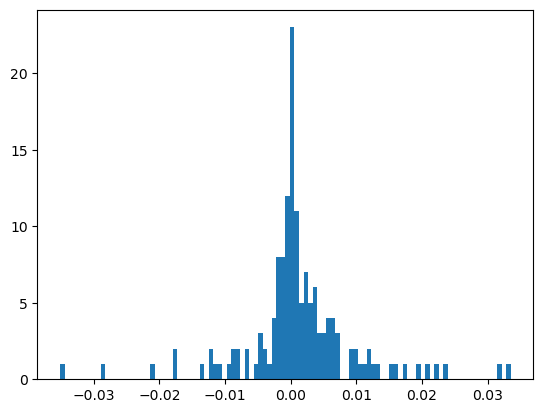

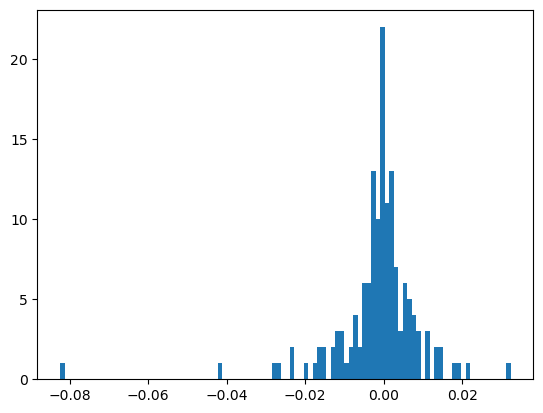

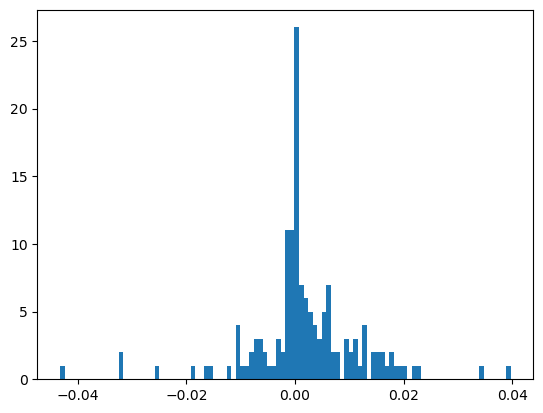

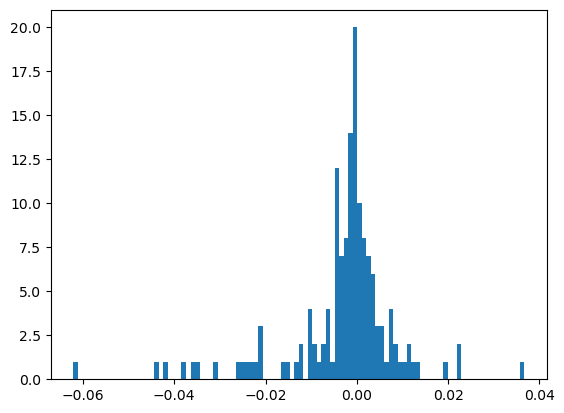

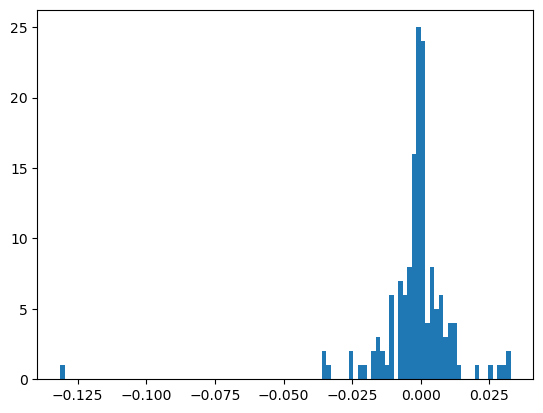

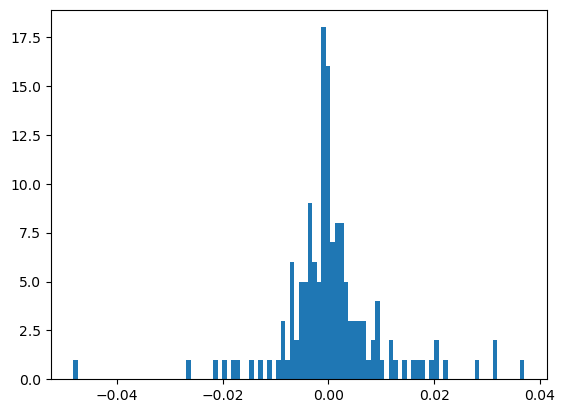

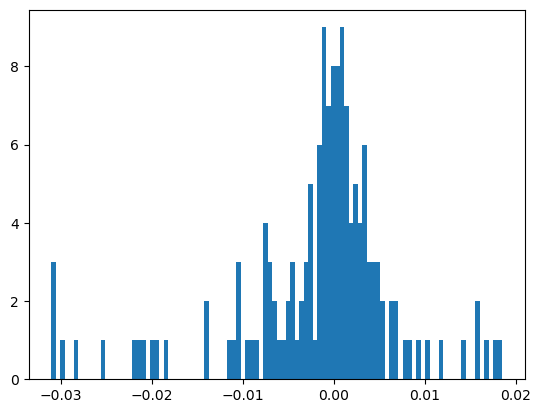

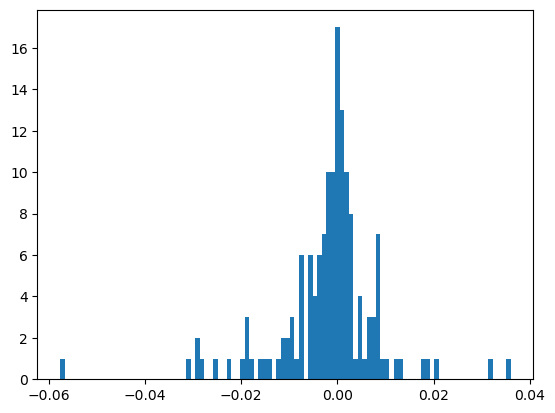

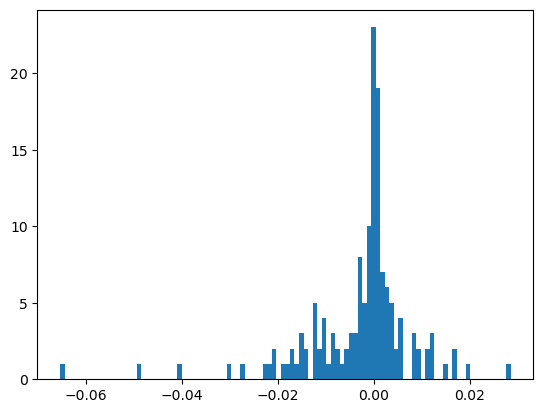

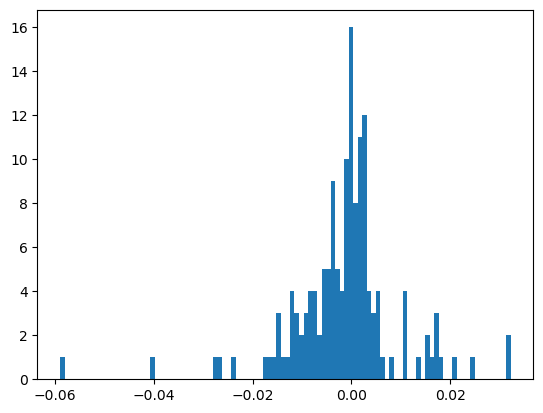

In [31]:
#Visualize some Perturbation hists
for run in np.arange(10):
    plt.hist((perturbed_corr[run,:,0,0].T - unperturbed_corr[run,0,0]).ravel(), bins = 100)
    plt.show()


In [32]:
#Define output directory 
out_dir = '~'

#Create Perturbation Correlation csv
out_df = pd.DataFrame(np.array([(perturbed_corr[:,:,0,0].T - unperturbed_corr[:,0,0]).T.ravel(), 
              perturbed_corr[:,:,0,0].ravel(), 
              np.repeat(unperturbed_corr[:,0,0].ravel(), 149)]).T, columns = ['Permuted Correlation Difference', 'Perturbed Correlation', 'Unperturbed Correlation'])

#Save df to csv
out_df.to_csv(f'{out_dir}/Perturbation_null_dist_mPTB.csv')


In [39]:
#Check significance at alpha = .1 (adjusted by feature size)

p_adj = .1/149
low_tail = np.percentile(( unperturbed_corr[:,0,0]- perturbed_corr[:,:,0,0].T).T.ravel(), (p_adj/2)*100)
high_tail = np.percentile(( unperturbed_corr[:,0,0] - perturbed_corr[:,:,0,0].T).T.ravel(), (1-p_adj/2)*100)

print(low_tail)
print(high_tail)

-0.07162325911702705
0.09274980621628232


In [40]:
#Check significance at alpha = .15 (adjusted by feature size)

p_adj = .15/149
low_tail = np.percentile(( unperturbed_corr[:,0,0]- perturbed_corr[:,:,0,0].T).T.ravel(), (p_adj/2)*100)
high_tail = np.percentile(( unperturbed_corr[:,0,0] - perturbed_corr[:,:,0,0].T).T.ravel(), (1-p_adj/2)*100)

print(low_tail)
print(high_tail)

-0.06719684114495414
0.08664995053599801


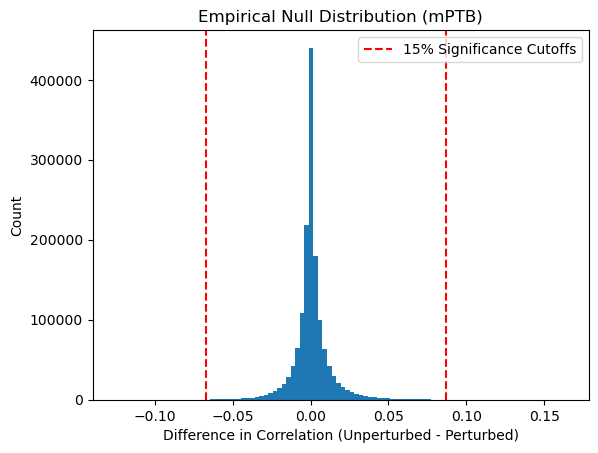

In [41]:
#Plot Histograms with 15% cuttoffs

plt.hist((unperturbed_corr[:,0,0] - perturbed_corr[:,:,0,0].T).ravel(), bins = 100)
plt.axvline(low_tail, color = 'r', ls ='--')
plt.axvline(high_tail, color = 'r', ls ='--')
plt.xlabel('Difference in Correlation (Unperturbed - Perturbed)')
plt.ylabel('Count')
plt.title('Empirical Null Distribution (mPTB)')
plt.legend(['15% Significance Cutoffs'])
plt.savefig(f'{out_dir}/Perturbation_Null_Dist_w_Cutoffs_mPTB.pdf')
plt.show()

# sPTB checks

In [4]:
#Load in and view sPTB data

path_to_data = '/mnt/c/Users/lukaak2/Downloads/20250318_sPTB_vs_ctrl_unprocessed_LK.csv'

data = pd.read_csv(path_to_data, index_col=0)
data

,bmi1,Type2,seq.10714.7,seq.25057.2,seq.4533.76,seq.4125.52,seq.15312.14,seq.2500.2,seq.7210.25,seq.12433.8,...,seq.7871.16,seq.13416.8,seq.9199.6,seq.21762.32,seq.18175.65,seq.13098.93,seq.3191.50,seq.2878.66,seq.23571.93,seq.21754.5
38,28.19,1,9.158610,12.227496,10.053790,9.493255,13.133897,9.806711,9.643135,13.079301,...,11.882681,11.193032,11.822531,8.227375,13.117059,12.289961,9.579693,10.454711,12.408038,10.833523
79,20.11,1,9.259037,11.455841,10.040290,11.555644,11.728303,8.954487,11.069651,12.729302,...,13.526022,12.683938,10.884018,8.282625,13.597750,13.342672,9.576106,10.053383,13.808522,10.120627
8,23.35,1,9.210915,11.744582,10.376777,10.292092,12.649615,9.831149,11.004291,12.872309,...,13.271799,12.179443,10.840699,8.499846,13.955332,12.777646,10.004642,10.366869,12.766632,10.659907
45,31.74,1,9.568526,10.838652,10.531479,10.080551,10.508785,9.099085,9.973554,12.394463,...,13.664281,11.600981,10.797580,8.505415,13.363177,9.964341,9.982566,9.802032,11.091898,9.612500
40,21.38,1,9.293472,11.952050,10.015973,11.372484,12.375039,9.352926,9.879124,12.889143,...,13.500020,11.549255,11.163461,8.230261,13.317610,13.250461,9.500643,10.190195,11.868591,10.576768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,35.44,0,9.579693,12.323533,10.213833,9.452447,13.194726,9.697489,10.873752,12.817683,...,13.486898,11.821495,10.733609,8.394034,13.672116,12.739675,9.799767,10.348396,12.524884,10.895348
44,30.95,0,9.431707,11.834194,10.036311,11.400239,12.018165,9.100662,11.298063,12.494906,...,13.687354,12.308936,10.940974,8.203593,13.430230,13.291876,9.490450,10.123604,11.496305,10.297375
47,31.48,0,9.331589,12.177077,9.957247,10.238166,12.922584,9.646019,10.138656,12.433272,...,13.878693,11.752966,10.861552,8.114783,13.817893,13.487187,9.449768,10.526304,11.896786,10.698010
2,34.66,0,9.316055,12.970933,10.261742,10.902149,13.691056,10.257506,10.173302,13.389564,...,12.344878,11.042549,11.126575,8.241268,13.821326,12.347151,9.697315,10.908242,12.447161,10.820498


In [5]:
#Set input and output indices (BMI and mPTB)
input_features_idx = np.array([0])
output_features_idx = np.array([1])

#Z-score data
X = (data.values - np.mean(data.values, axis = 0))/np.std(data.values, axis = 0)

In [6]:
#Run Perturbation 
runs = 10000 #HIGHLY SUGGESTED TO RUN LARGE NUMBER OF RUNS ON CLUSTER/WITH PARALLELIZATION

perturbed_corr, unperturbed_corr = perturb_permutation(X, runs = runs,input_features_idx= input_features_idx, output_features_idx=output_features_idx,lambda_min = .02, lambda_max = .2, nedges = 1682)

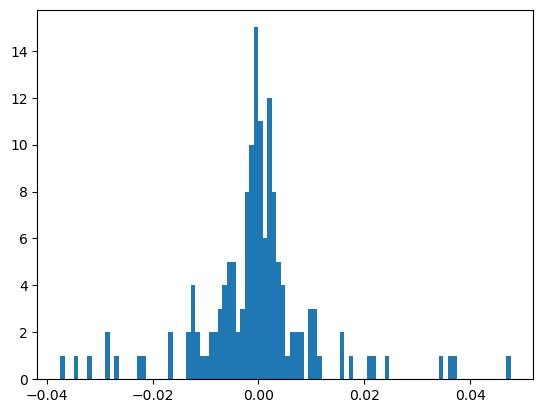

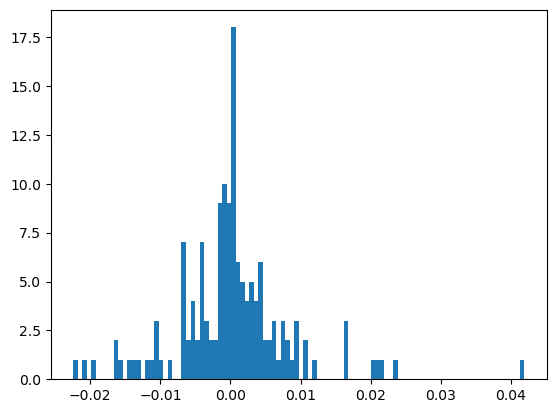

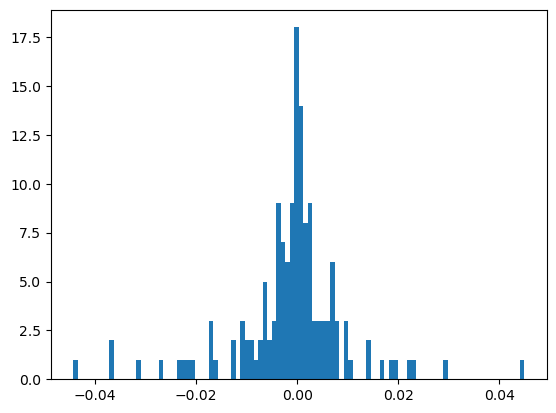

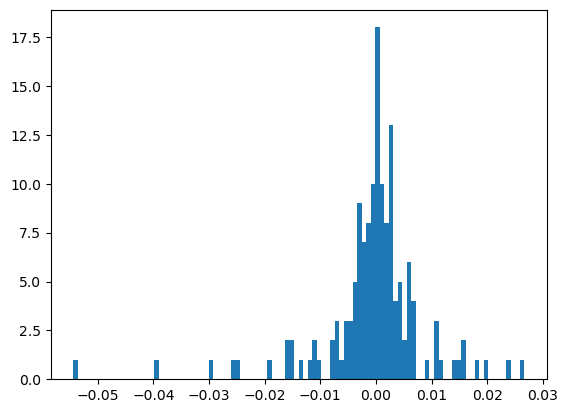

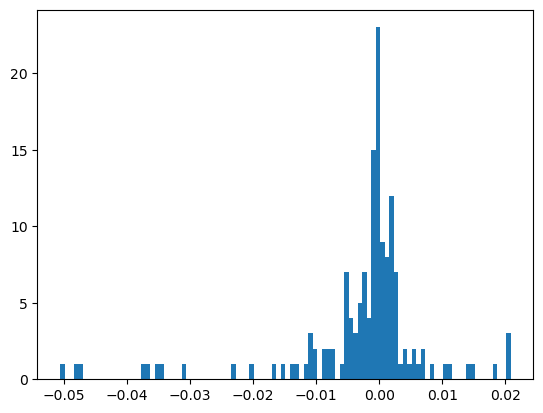

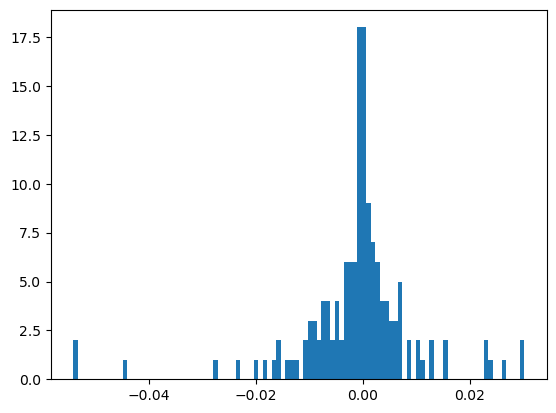

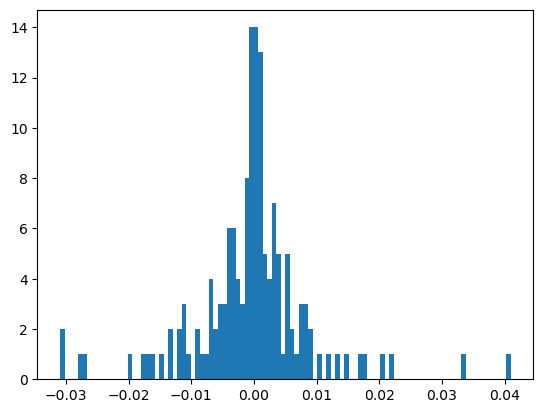

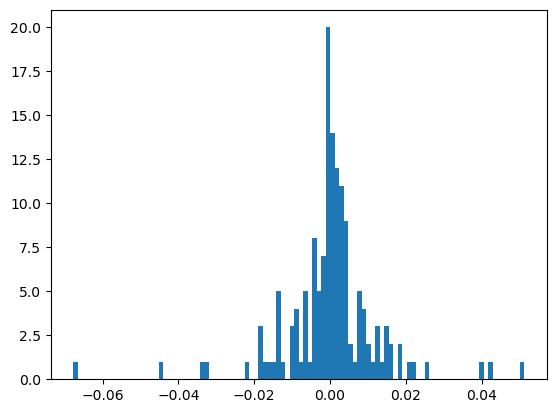

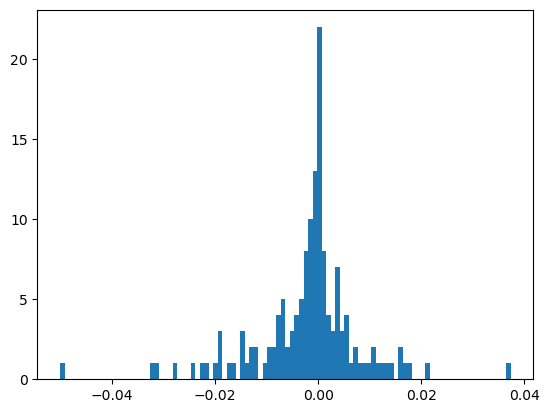

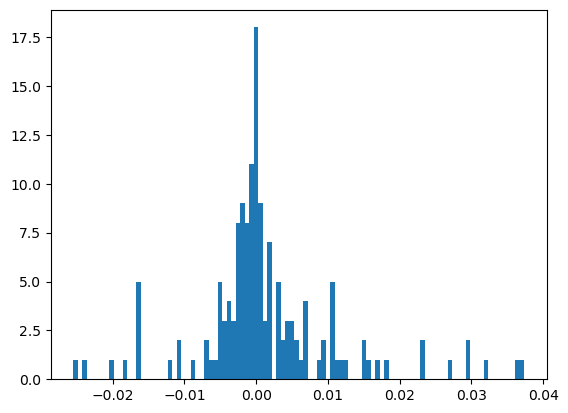

In [8]:
#Visualize some Perturbation hists
for run in np.arange(10):
    plt.hist((perturbed_corr[run,:,0,0].T - unperturbed_corr[run,0,0]).ravel(), bins = 100)
    plt.show()


In [29]:
#Define output directory 
out_dir = '~'

#Create Perturbation Correlation csv
out_df = pd.DataFrame(np.array([(perturbed_corr[:,:,0,0].T - unperturbed_corr[:,0,0]).T.ravel(), 
              perturbed_corr[:,:,0,0].ravel(), 
              np.repeat(unperturbed_corr[:,0,0].ravel(), 149)]).T, columns = ['Permuted Correlation Difference', 'Perturbed Correlation', 'Unperturbed Correlation'])

#Save df to csv
out_df.to_csv(f'{out_dir}/Perturbation_null_dist_sPTB.csv')

In [24]:
#Check significance at alpha = .05 (adjusted by feature size)
p_adj = .05/149
low_tail = np.percentile((unperturbed_corr[:,0,0] - perturbed_corr[:,:,0,0].T).T.ravel(), (p_adj/2)*100)
high_tail = np.percentile((unperturbed_corr[:,0,0] - perturbed_corr[:,:,0,0].T).T.ravel(), (1-p_adj/2)*100)

print(low_tail)
print(high_tail)

-0.0891314712041069
0.08894947810066439


In [13]:
#Check significance at alpha = .1 (adjusted by feature size)
p_adj = .1/149
low_tail = np.percentile((perturbed_corr[:,:,0,0].T - unperturbed_corr[:,0,0]).T.ravel(), (p_adj/2)*100)
high_tail = np.percentile((perturbed_corr[:,:,0,0].T - unperturbed_corr[:,0,0]).T.ravel(), (1-p_adj/2)*100)

print(low_tail)
print(high_tail)

-0.08144058002357572
0.08028204815890685


In [31]:
#Check significance at alpha = .15 (adjusted by feature size)
p_adj = .15/149
low_tail = np.percentile((perturbed_corr[:,:,0,0].T - unperturbed_corr[:,0,0]).T.ravel(), (p_adj/2)*100)
high_tail = np.percentile((perturbed_corr[:,:,0,0].T - unperturbed_corr[:,0,0]).T.ravel(), (1-p_adj/2)*100)

print(low_tail)
print(high_tail)

-0.07780646670089418
0.07538826126066858


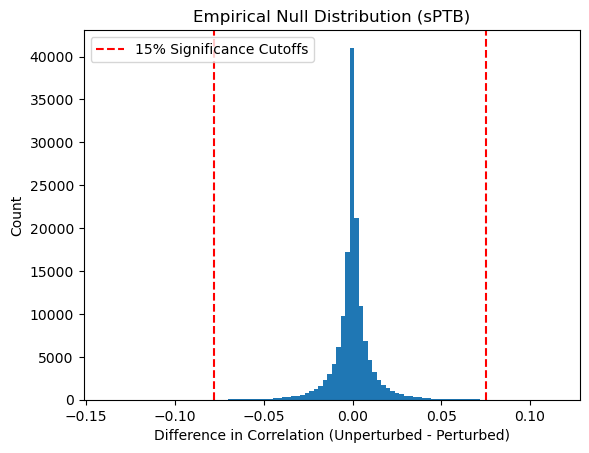

In [33]:
#Plot Histograms with 15% cuttoffs

plt.hist((unperturbed_corr[:,0,0] - perturbed_corr[:,:,0,0].T).ravel(), bins = 100)
plt.axvline(low_tail, color = 'r', ls ='--')
plt.axvline(high_tail, color = 'r', ls ='--')
plt.xlabel('Difference in Correlation (Unperturbed - Perturbed)')
plt.ylabel('Count')
plt.title('Empirical Null Distribution (sPTB)')
plt.legend(['15% Significance Cutoffs'])
plt.savefig(f'{out_dir}/Perturbation_Null_Dist_w_Cutoffs_sPTB.pdf')
plt.show()